# 08. 안전 운전자 예측

* 안전 운전자 예측 경진대회: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

### 0. 학습순서
1. 경진대회 이해
2. 탐색적 데이터 분석 (EDA)
3. 베이스라인 모델 (LightGBM)
4. 성능 개선 I   (LightGBM + feature engineering + hyper-parameter opt.)
5. 성능 개선 II  (XGBoost)
6. 성능 개선 III (Ensenbles)

### 1. 경진대회 이해

* 브라질 보험회사(포르투 세구로)에서 주최
* 목표: 운전자가 보험료를 청구할 확률 예측
* 데이터 특징: 
   - 고객 특정할 수 없도록 비식별화
   - 결측값 많음, 결측값을 -1로 표기
   - 타깃값 (이항분류): 0(보험청구_N) or 1(보험청구_Y)

* Scoring metric: 정규화된 지니계수(Gini Coefficient)

* 지니계수
    - 어떤 값의 분배상태를 표현하기 위한 로렌츠 곡선을 이용하여 값의 분배 정도를 수치화하는 방법
    - 아래 이미지는 로렌츠 곡선으로, X축은 데이터 수의 누적 비율이고, Y축은 데이터 value의 누적 비율
        - GINI = A / (A+B)
        - GINI = (2*AUC)–1
    - 머신러닝 분야에서는 Decision Tree Model의 성능평가를 하는 데 사용
    - 1에 가까울수록 변별력이 큰 것으로 판단, 0.6 이상이면 변별력이 뛰어난 것으로 판단
    - 
* 정규화된 지니계수
    - 정규화 지니계수 = (예측값 지니계수) / (예측 완벽할 때의 지니계수)
    - 0에 가까울수록 성능이 나쁘고, 1에 가까울수록 성능 높음
    - https://vincenthanna.tistory.com/entry/Gini-coefficient

<img src="ginipng.png" height="500px" width="500px">

### 2. 탐색적 데이터 분석 (EDA)

#### 2.1. 데이터 둘러보기

In [4]:
import pandas as pd

# 데이터 경로
data_path = './input/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [2]:
train.shape, test.shape

((595212, 58), (892816, 57))

In [3]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
train.columns

Index(['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      

In [5]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [6]:
test.columns

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [7]:
train.columns[1:] == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [8]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

In [10]:
'''
feature에 일정한 형식
[분류]_[분류별 일련번호]_[데이터종류]
1. ind/reg/car/calc : 분류
2. 01/02/03/... : 분류별 일련 번호
3. bin/cat/(생략) : 이진피처/명목형피처/순서or연속형피처
'''

'\nfeature에 일정한 형식\n[분류]_[분류별 일련번호]_[데이터종류]\n1. ind/reg/car/calc : 분류\n2. 01/02/03/... : 분류별 일련 번호\n3. bin/cat/(생략) : 이진피처/명목형피처/순서or연속형피처\n'

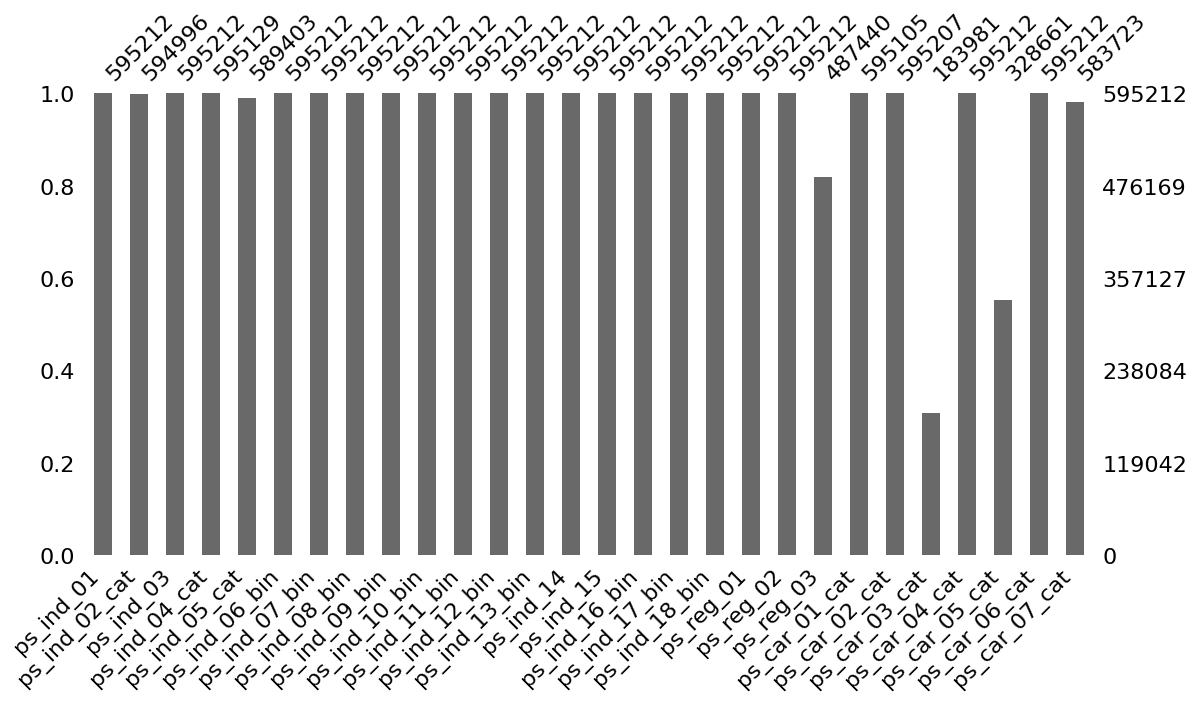

In [11]:
import numpy as np
import missingno as msno

# 훈련 데이터 복사본에서 -1을 np.NaN로 변환
train_copy = train.copy().replace(-1, np.NaN)

# 결측값 시각화(처음 28개만)
msno.bar(df=train_copy.iloc[:, 1:29], figsize=(13, 6));

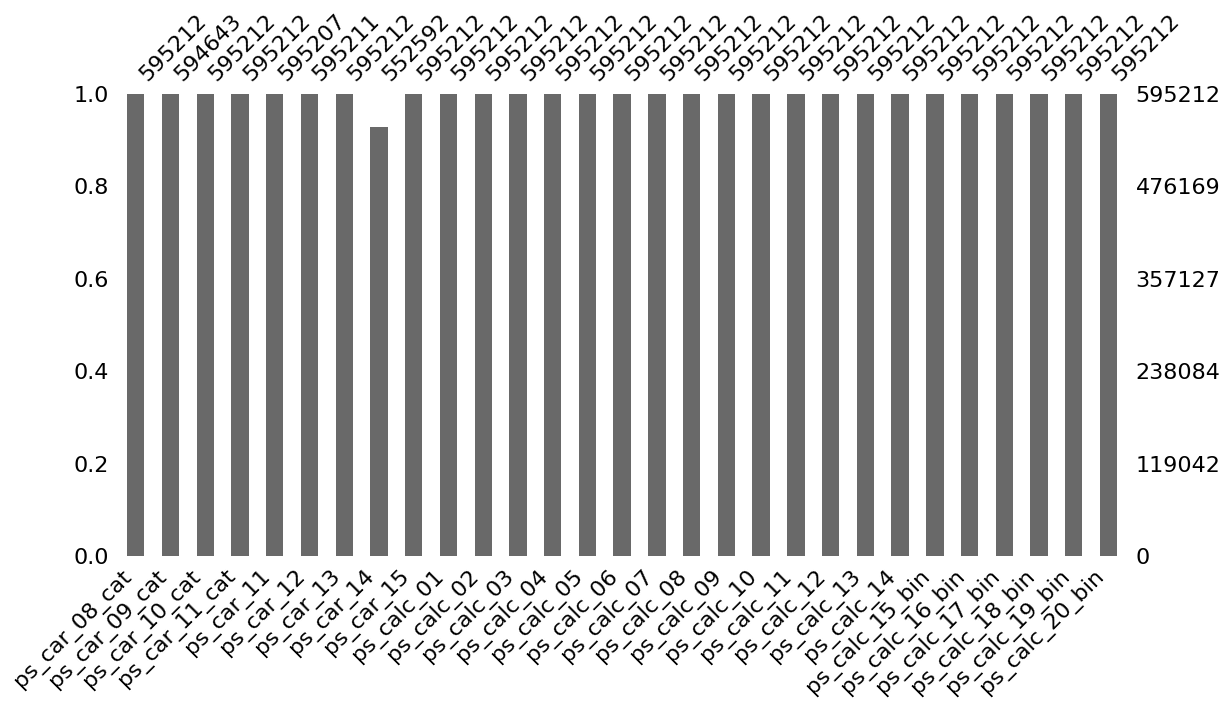

In [12]:
msno.bar(df=train_copy.iloc[:, 29:], figsize=(13, 6));

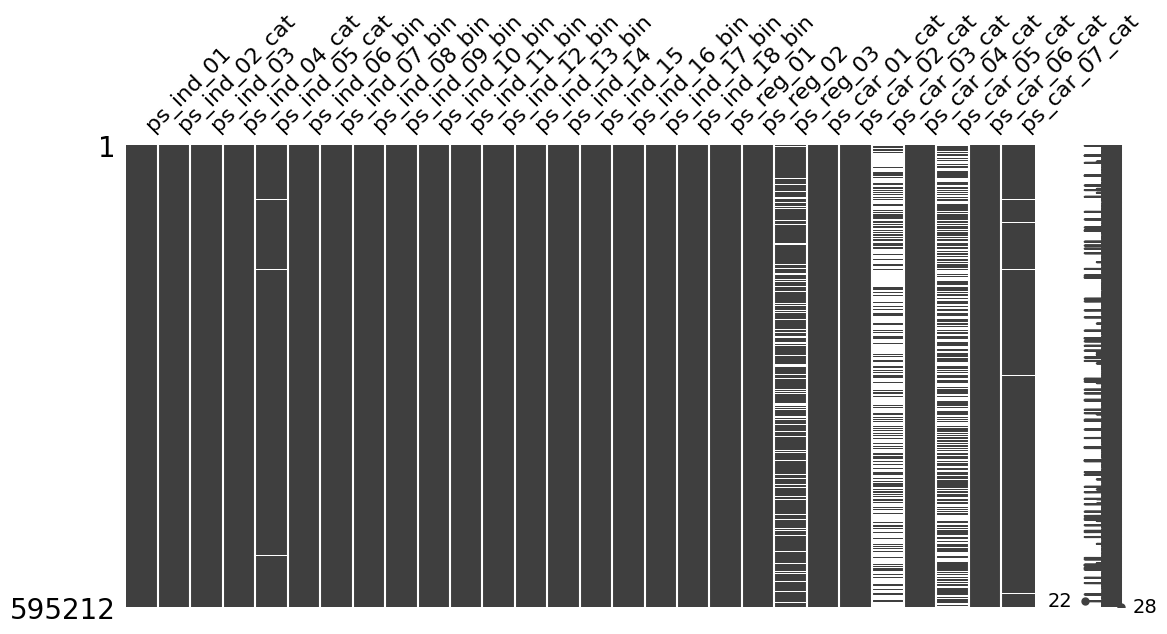

In [13]:
msno.matrix(df=train_copy.iloc[:, 1:29], figsize=(13, 6));

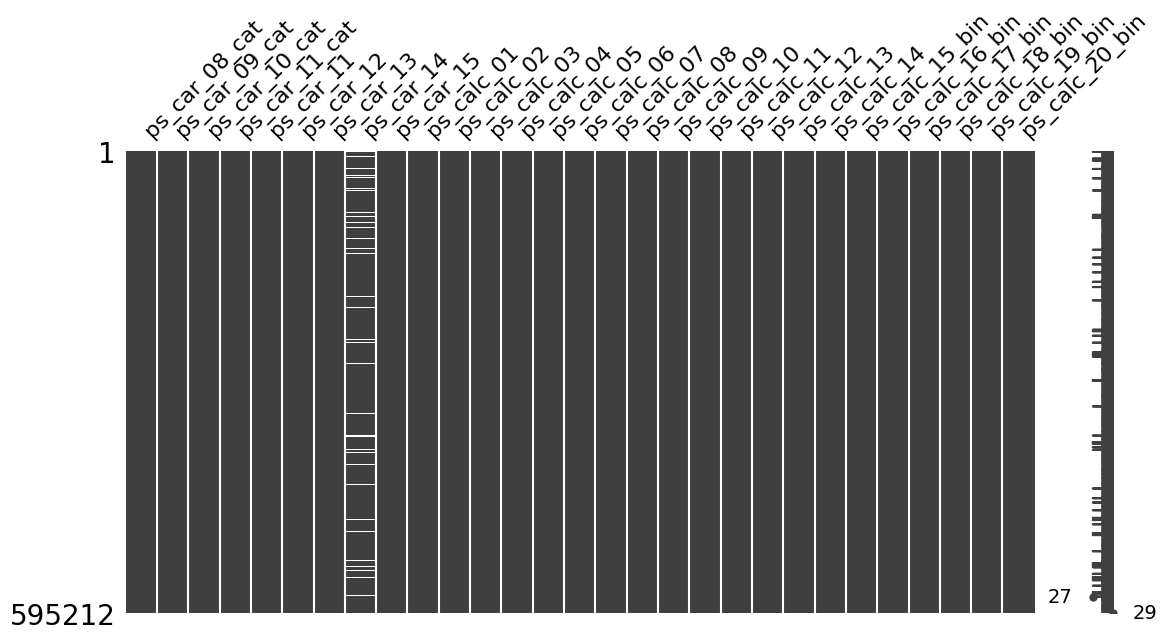

In [14]:
msno.matrix(df=train_copy.iloc[:, 29:], figsize=(13, 6));

In [15]:
## 피처 요약표

def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df == -1).sum().values # 피처별 -1 개수
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [16]:
summary = resumetable(train)
summary

데이터 세트 형상: (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [17]:
summary[summary['데이터 종류'] == '명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [18]:
summary[summary['데이터 종류'] == '연속형'].index

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')

In [19]:
summary[summary['데이터 타입'] == 'float64'].index

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')

#### 2.2. 데이터 시각화

In [20]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

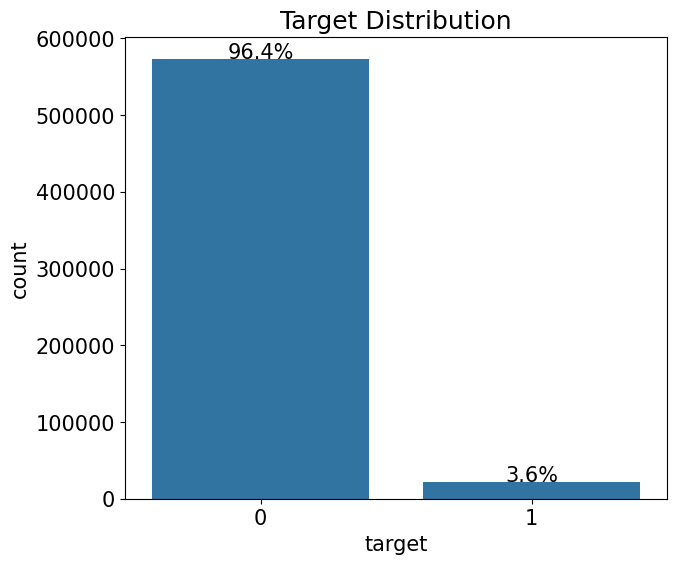

In [21]:
## 타깃값 분포
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(left_coord + width/2.0,     # x축 위치
                height + total_size*0.001,  # y축 위치
                '{:1.1f}%'.format(percent), # 입력 텍스트
                ha='center')                # 가운데 정렬
    
mpl.rc('font', size=15)
plt.figure(figsize=(7, 6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train)) # 비율 표시
ax.set_title('Target Distribution');

In [22]:
'''
타깃값이 불균형 하기에 비율이 작은 타깃값 1을 잘 예측하는게 중요
- 고윳값에 따라 타깃값 비율이 달라야 그 피처가 타깃값 예측에 도움
- 신뢰구간이 좁아서 어느 정도 통계적으로 유효성이 되어야 타깃값 예측에 도움
=> 고윳값별 타깃값 1 비율이 충분히 차이가 나고 신뢰구간도 작은 피처여야 모델링에 도움
'''

'\n타깃값이 불균형 하기에 비율이 작은 타깃값 1을 잘 예측하는게 중요\n- 고윳값에 따라 타깃값 비율이 달라야 그 피처가 타깃값 예측에 도움\n- 신뢰구간이 좁아서 어느 정도 통계적으로 유효성이 되어야 타깃값 예측에 도움\n=> 고윳값별 타깃값 1 비율이 충분히 차이가 나고 신뢰구간도 작은 피처여야 모델링에 도움\n'

In [23]:
## 이진피처
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, 
                                  size=(12, 18)):
    mpl.rc('font', size=9) 
    plt.figure(figsize=size)                     # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        # ax축에 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
        sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
    plt.show()


/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax

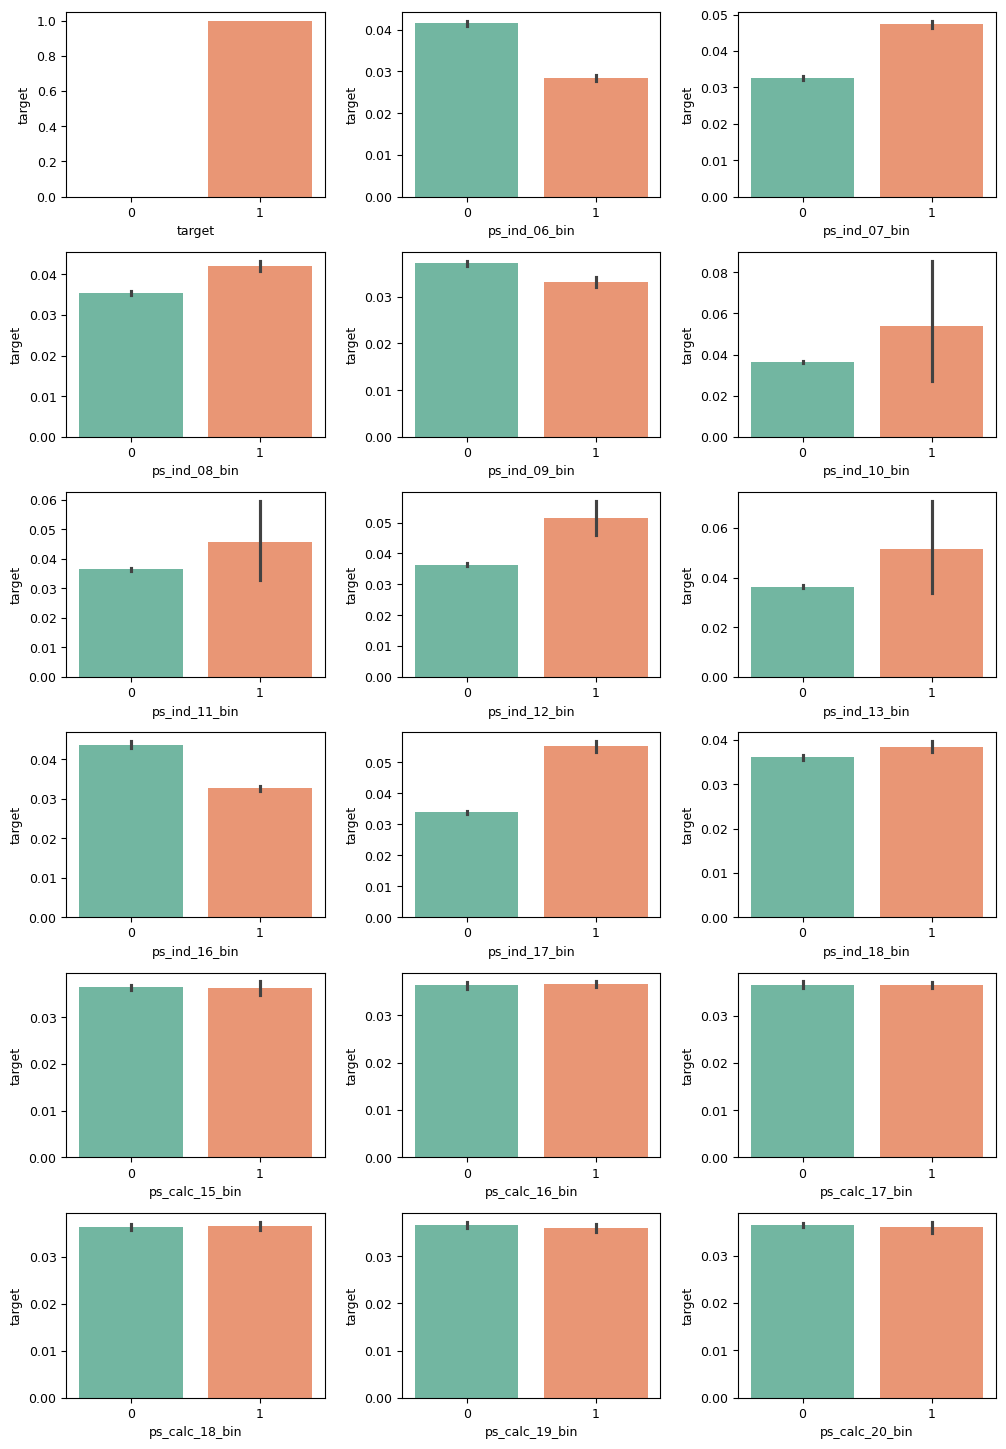

In [24]:
bin_features = summary[summary['데이터 종류'] == '이진형'].index # 이진 피처
# 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
plot_target_ratio_by_features(train, bin_features, 6, 3) # 6행 3열 배치

In [25]:
'''
제거할 피처
1) 신뢰구간 넓어 통계적 유효성 떨어짐 - ps_ind_10_bin ～ ps_ind_13_bin
2) 고유값 별 타깃값 비율 차이 없어 예측력 없음 - ps_calc_15_bin ～ ps_calc_20_bin
'''

'\n제거할 피처\n1) 신뢰구간 넓어 통계적 유효성 떨어짐 - ps_ind_10_bin ～ ps_ind_13_bin\n2) 고유값 별 타깃값 비율 차이 없어 예측력 없음 - ps_calc_15_bin ～ ps_calc_20_bin\n'

/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax

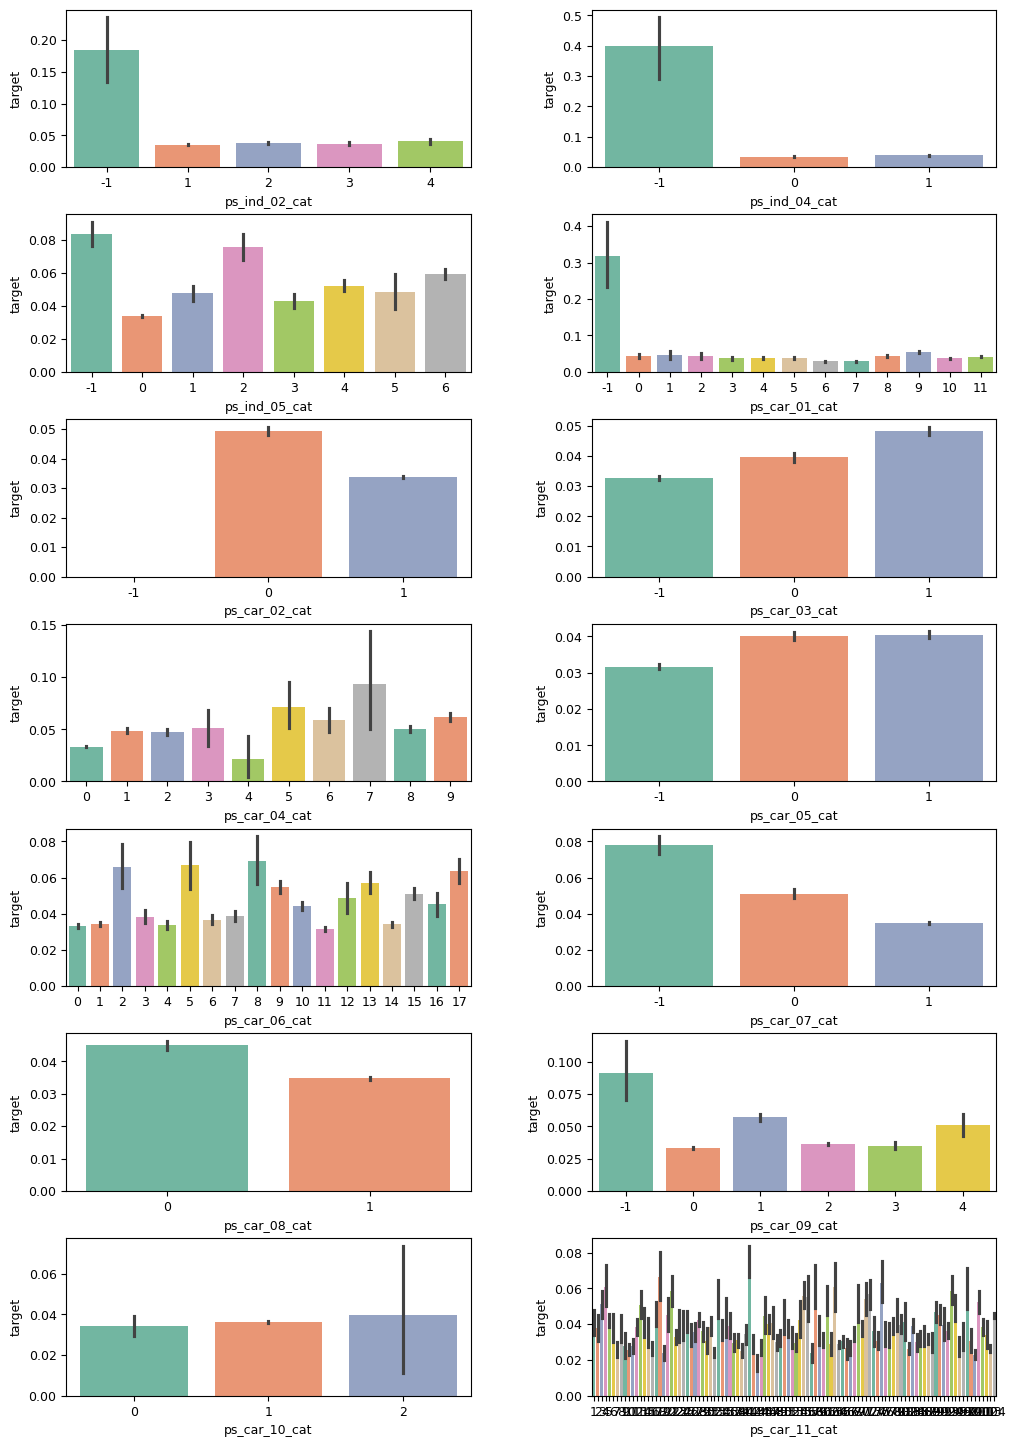

In [26]:
## 명목형 피처
nom_features = summary[summary['데이터 종류'] == '명목형'].index # 명목형 피처

plot_target_ratio_by_features(train, nom_features, 7, 2) # 7행 2열


In [27]:
'''
결측값 자체에 타깃 예측력이 있다면 고윳값으로 간주
- ps_ind_02_cat, ps_ind_04_cat, ps_car_01_cat: 신뢰구간 크더라도, 해당 -1 값 신뢰 하한이 다른 값들의 신뢰 상한과 차이가 큼
=> 명목형 변수는 모두 모델링에 사용
'''

'\n결측값 자체에 타깃 예측력이 있다면 고윳값으로 간주\n- ps_ind_02_cat, ps_ind_04_cat, ps_car_01_cat: 신뢰구간 크더라도, 해당 -1 값 신뢰 하한이 다른 값들의 신뢰 상한과 차이가 큼\n=> 명목형 변수는 모두 모델링에 사용\n'

/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/3495871415.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax

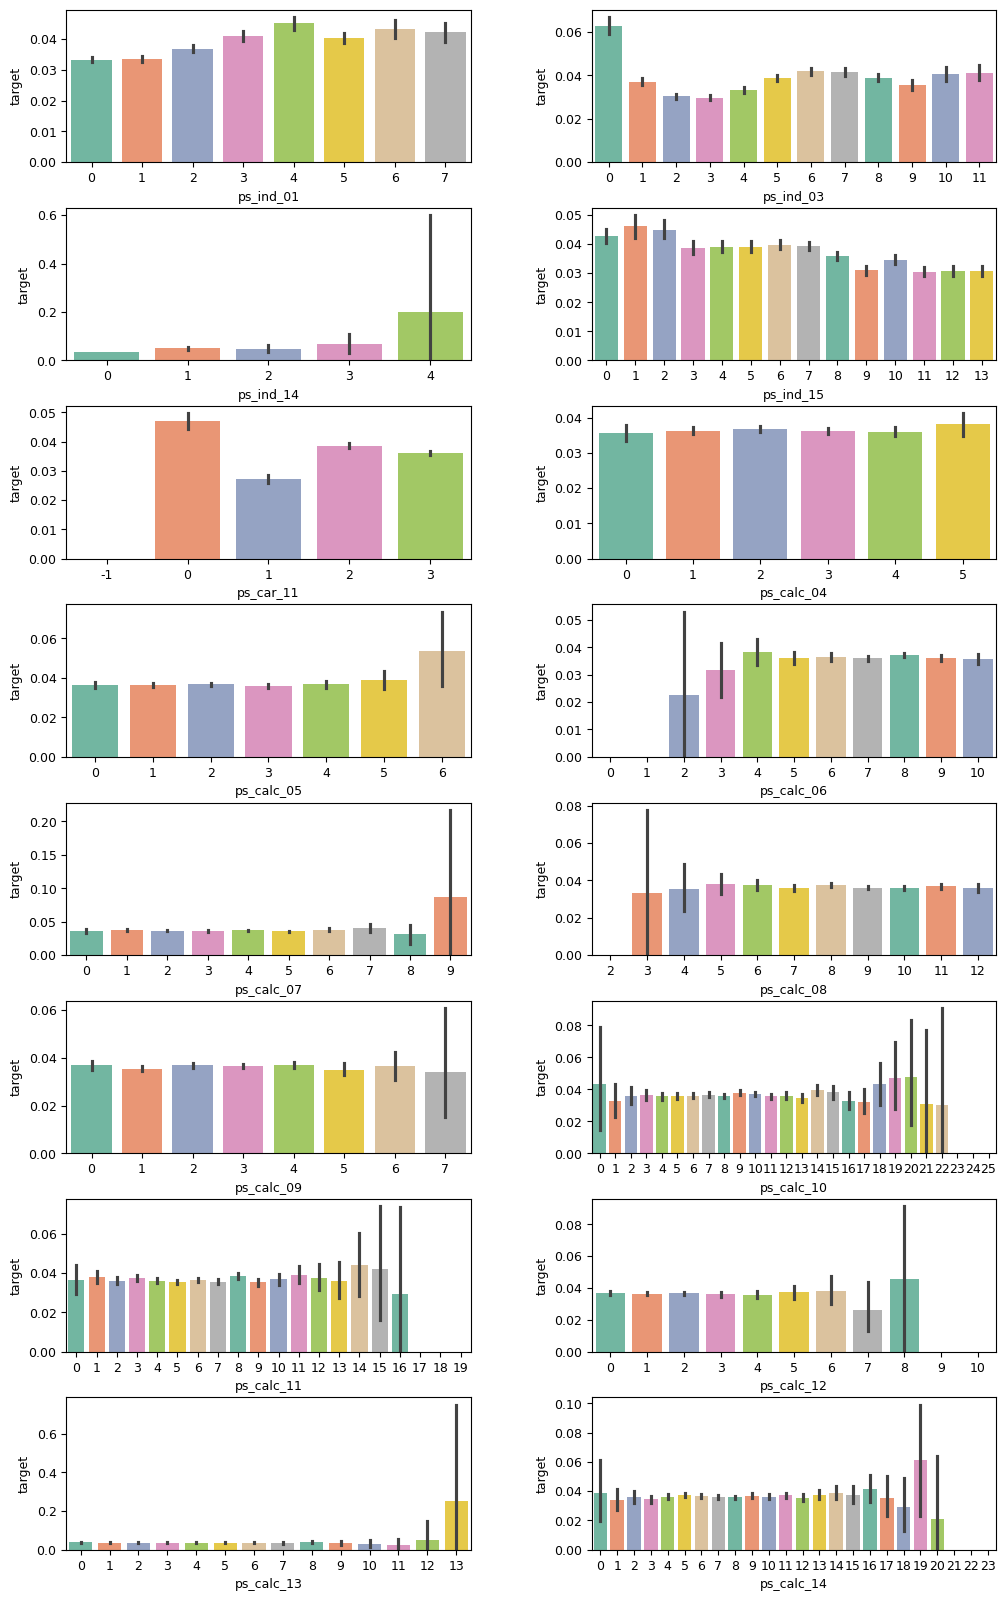

In [28]:
## 순서형 피처
ord_features = summary[summary['데이터 종류'] == '순서형'].index # 순서형 피처

plot_target_ratio_by_features(train, ord_features, 8, 2, (12, 20)) # 8행 2열

In [29]:
'''
제거할 피처
1) 타깃값 비율 신뢰구간 넓어 통계적 유효성 떨어짐 - ps_ind_14
2) 고윳값별 타깃값 비율 차이 없음 - ps_cals_04 ～ ps_cals_14
'''

'\n제거할 피처\n1) 타깃값 비율 신뢰구간 넓어 통계적 유효성 떨어짐 - ps_ind_14\n2) 고윳값별 타깃값 비율 차이 없음 - ps_cals_04 ～ ps_cals_14\n'

/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/4176580638.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/4176580638.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
/var/folders/sy/4nj9shsj5tv6xmz0c438d_ph0000gn/T/ipykernel_2074/4176580638.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cont_feature, y='target', data=trai

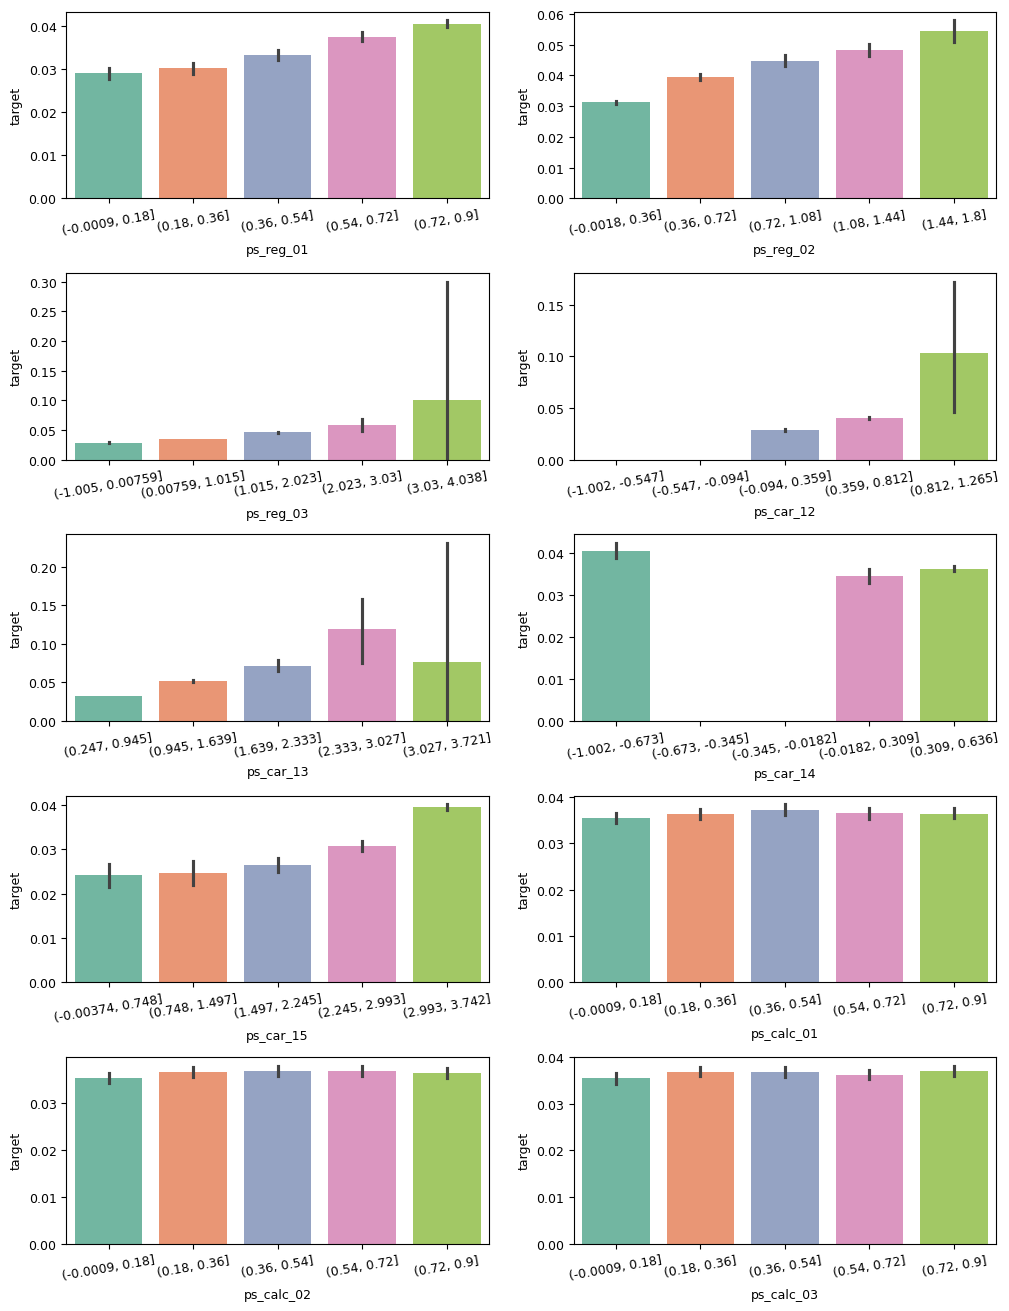

In [30]:
## 연속형 피처
cont_features = summary[summary['데이터 종류'] == '연속형'].index # 연속형 피처

plt.figure(figsize=(12, 16))                # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)              # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.4) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    train[cont_feature] = pd.cut(train[cont_feature], 5)

    ax = plt.subplot(grid[idx])                # 분포도를 그릴 서브플롯 설정
    sns.barplot(x=cont_feature, y='target', data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전

In [31]:
'''
** pd.cut() 활용하여 연속형 변수를 범주화 (구간으로 나눔)
제거할 피처
1) 구간별 타깃값 비율 차이가 없음 - ps_calc_01 ～ ps_calc_03
'''

'\n** pd.cut() 활용하여 연속형 변수를 범주화 (구간으로 나눔)\n제거할 피처\n1) 구간별 타깃값 비율 차이가 없음 - ps_calc_01 ～ ps_calc_03\n'

In [32]:
# 변수간 상관 관계 확인
train_copy = train_copy.dropna() # np.NaN 값 삭제 <- 결측 값 있으면 상관관계 올바르게 구하지 못함

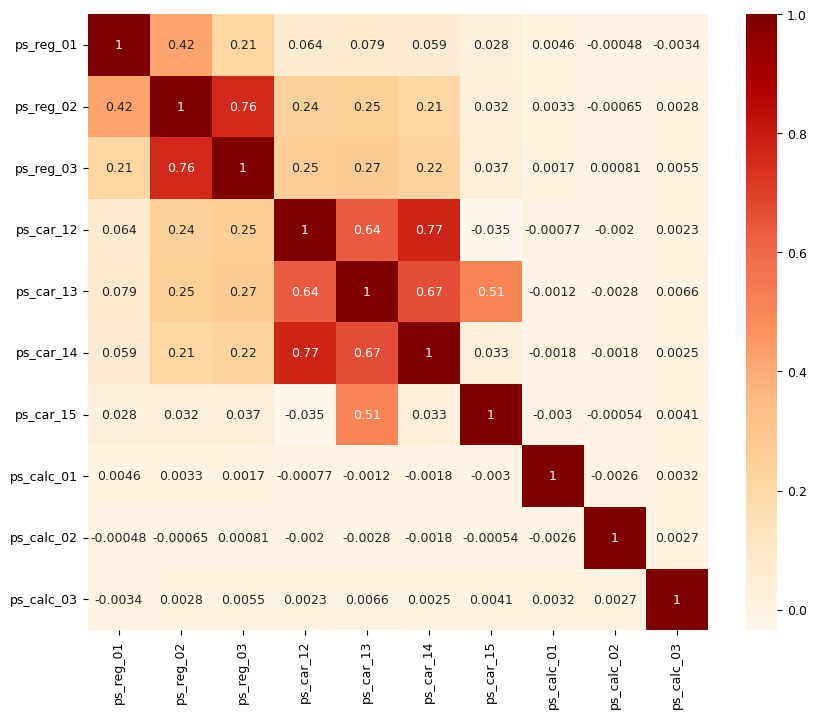

In [33]:
plt.figure(figsize=(10, 8))
cont_corr = train_copy[cont_features].corr()     # 연속형 피처 간 상관관계 
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # 히트맵 그리기

In [34]:
'''
상관계수 0.77: ps_car_12 & ps_car_14 -> ps_car_14 제거 시 성능 향상
상관계수 0.76: ps_reg_02 & ps_reg_03 -> ps_reg_02 / ps_reg_03 제거 시 성능 하락
'''

'\n상관계수 0.77: ps_car_12 & ps_car_14 -> ps_car_14 제거 시 성능 향상\n상관계수 0.76: ps_reg_02 & ps_reg_03 -> ps_reg_02 / ps_reg_03 제거 시 성능 하락\n'

### 3. 베이스라인 모델 (LightGBM)

#### 3.1. 피처 엔지니어링

In [1]:
## 데이터 불러오기
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

NameError: name 'pd' is not defined

In [ ]:
## 데이터 합치기 <- 두 데이터 동일한 인코딩 적용
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거 <- 피처에만 인코딩 적용

In [ ]:
all_features = all_data.columns # 전체 피처
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [38]:
## 명목형 피처 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처 추출
cat_features = [feature for feature in all_features if 'cat' in feature] 

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성
# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

In [39]:
## 필요 없는 피처 제거
# 추가로 제거할 피처
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# '1) one-hot 변환되기 전 명목형 피처, 2) calc 분류의 피처, 3) 추가 제거할 피처'를 제외한 피처
remaining_features = [feature for feature in all_features 
                      if ('cat' not in feature and 
                          'calc' not in feature and 
                          feature not in drop_features)]

In [40]:
## 명목형 피처 원-핫 인코딩 + 필요없는 피처 제거한 데이터
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')

<img src="csr.png" height="500px" width="800px">

In [41]:
## 데이터 나누기
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

# 타겟값 할당
y = train['target'].values

#### 3.2. 평가지표 계산 함수 작성

In [27]:
## 정규화 지니계수 계산 함수
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [28]:
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

#### 3.3. 모델 훈련 및 성능 검증

### OOF (Out of Fold prediction)
* K폴드 교차검증 수행하면서 폴드마다 테스트 데이터로 예측
* 장점: 1) 과대적합 방지 효과, 2) 앙상블 효과로 모델 성능 좋아짐
* label이 불균형할 때는 층화 K폴드 방식 활용 - 타깃값이 균등하게 배치되도록 폴드 나눔

<img src="oof.png" height="500px" width="1100px">

In [44]:
## OOF 방식으로 LightGBM 훈련¶
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991) #시계열 데이터인 경우에는 shuffle=False

In [45]:
params = {'objective': 'binary',     # 이진 분류 문제
          'learning_rate': 0.01,     
          'force_row_wise': True,    # 경고문구 삭제
          'random_state': 0}   

In [46]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

In [48]:
import lightgbm as lgb
from lightgbm import early_stopping

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정 
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성 
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋

    # LightGBM 모델 훈련 
    lgb_model = lgb.train(params=params,        # 훈련용 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=1000, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini,           # 검증용 평가지표
                          callbacks=[early_stopping(stopping_rounds=100)], # 조기종료 조건
                          #early_stopping_rounds=100, # 조기종료 조건
                          #verbose_eval=100)     # 100번째마다 점수 출력
    )
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[681]	valid_0's binary_logloss: 0.151659	valid_0's gini: 0.289034
폴드 1 지니계수 : 0.2890336154188232

######################################## 폴드 2 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1093
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[

In [49]:
print('OOF 검증 데이터 지니계수:', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수: 0.2804995714877777


#### 3.4. 예측 및 결과 제출

In [50]:
submission['target'] = oof_test_preds
submission.to_csv('submission_1.csv')

<img src="result_1.png" height="150px" width="800px">

### 4. 성능 개선 I   (LightGBM + feature engineering + hyper-parameter opt.)

#### 4.1. 피처 엔지니어링

In [5]:
## 데이터 불러오기
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [6]:
## 데이터 합치기
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

all_features = all_data.columns # 전체 피처

In [7]:
## 명목형 피처 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처
cat_features = [feature for feature in all_features if 'cat' in feature] 

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

In [8]:
'''
파생 피처 추가
1) 데이터 당 결측 값 개수
2) ind 피치값 연결
3) 명목형 피처의 고윳값별 개수
'''

'\n파생 피처 추가\n1) 데이터 당 결측 값 개수\n2) ind 피치값 연결\n3) 명목형 피처의 고윳값별 개수\n'

In [9]:
## 파생 피처 추가
# '데이터 하나당 결측값 개수'를 파생 피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [10]:
# 명목형 피처, calc 분류의 피처를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)] 
# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

In [11]:
# 분류가 ind인 피처 concat (e.g., 2_2_5)
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [12]:
all_data['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [13]:
# 명목형 피처의 고윳값별 개수
all_data['ps_ind_02_cat'].value_counts().to_dict()

{1: 1079327, 2: 309747, 3: 70172, 4: 28259, -1: 523}

In [14]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

In [15]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

In [16]:
all_data[['ps_ind_02_cat', 'ps_ind_02_cat_count']]

,ps_ind_02_cat,ps_ind_02_cat_count
0,2,309747
1,1,1079327
2,4,28259
3,1,1079327
4,2,309747
...,...,...
1488023,1,1079327
1488024,3,70172
1488025,1,1079327
1488026,1,1079327


In [17]:
'''
원핫 인코딩된 명목형 피처  (encoded_cat_matrix)
+
명목형피처 & calc 제외한 피처들 + num_missing (remaining_features)
+
파생피처 (cat_count_features)
'''

'\n원핫 인코딩된 명목형 피처  (encoded_cat_matrix)\n+\n명목형피처 & calc 제외한 피처들 + num_missing (remaining_features)\n+\n파생피처 (cat_count_features)\n'

In [18]:
## 필요없는 피처 제거
from scipy import sparse
# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

In [19]:
## 데이터 나누기
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [20]:
## 정규화 지니 계산 함수
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

### 4.2. 하이퍼파라미터 최적화

베이지안 최적화
- 미지의 함수가 반환하는 값의 최소 또는 최댓값을 만드는 최적해를 짧은 반복을 통해 찾아내는 최적화 방식
- 새로운 데이터를 입력 받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수를 도출
- 대체 모델(Surrogate Model = 사후 모델)과 획득 함수(activation function)로 구성
- 대체 모델은 획득 함수로부터 최적 입력 값을 추천 받은 뒤 이를 기반으로 최적 함수 모델을 개선
- 획득 함수는 개선된 대체 모델을 기반으로 다시 최적 입력 값을 계산

- Step1: 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링 하여 성능 결과를 관측
- Step2: 관측된 값을 기반으로 대체 모델은 최적 함수를 예측 추정
- Step3: 획득 함수에서 다음으로 관측할 하이퍼 파라미터 추출
- Step4: 해당 하이퍼 파라미터로 관측된 값을 기반으로 대체 모델은 다시 최적 함수 예측 추정

<img src="basy_opt.png" height="500px" width="800px">

In [21]:
## 데이터셋 준비
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=0)

# 베이지안 최적화용 데이터셋
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

In [22]:
''''
하이퍼 파라미터 범위 설정 TIP
1) 범위를 점점 좁혀가며 설정
2) 다른 상위권 캐글러 방법 참조
'''

"'\n하이퍼 파라미터 범위 설정 TIP\n1) 범위를 점점 좁혀가며 설정\n2) 다른 상위권 캐글러 방법 참조\n"

In [23]:
## 하이퍼파라미터 범위 설정
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'num_leaves': (30, 40),
                'lambda_l1': (0.7, 0.9),
                'lambda_l2': (0.9, 1),
                'feature_fraction': (0.6, 0.7),
                'bagging_fraction': (0.6, 0.9),
                'min_child_samples': (6, 10),
                'min_child_weight': (10, 40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary',
                'learning_rate': 0.005,
                'bagging_freq': 1,        # 배깅 수행 빈도
                'force_row_wise': True,   # 경고 문구 삭제
                'random_state': 1991}

In [45]:
##(베이지안 최적화용) 평가지표 계산 함수 작성
from lightgbm import early_stopping

def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    
    # 베이지안 최적화를 수행할 하이퍼파라미터 
    params = {'num_leaves': int(round(num_leaves)),                 # 베이지안 최적화에서는 범위 내 실숫값 탐색하기 때문에 정수로 변환 필요
              'lambda_l1': lambda_l1,
              'lambda_l2': lambda_l2,
              'feature_fraction': feature_fraction,
              'bagging_fraction': bagging_fraction,
              'min_child_samples': int(round(min_child_samples)),   # 베이지안 최적화에서는 범위 내 실숫값 탐색하기 때문에 정수로 변환 필요
              'min_child_weight': min_child_weight,
              'feature_pre_filter': False}
    # 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터:', params)    
    
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params, 
                           train_set=bayes_dtrain,
                           num_boost_round=2500,
                           valid_sets=bayes_dvalid,
                           feval=gini,
                           #early_stopping_rounds=300,
                           callbacks=[early_stopping(stopping_rounds=300)],
                           #verbose_eval=False)
    )
    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid) 
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [46]:
## 최적화 수행
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,      # 평가지표 계산 함수
                                 pbounds=param_bounds, # 하이퍼파라미터 범위
                                 random_state=0)


In [47]:
# 베이지안 최적화 수행

optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
Training until validation scores don't improve for 300 rounds
Did 

In [48]:
## 결과 확인
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']
max_params

{'bagging_fraction': 0.8675319002346239,
 'feature_fraction': 0.6963662760501029,
 'lambda_l1': 0.7766883037651555,
 'lambda_l2': 0.9791725038082665,
 'min_child_samples': 8.115579679011617,
 'min_child_weight': 27.04133683281797,
 'num_leaves': 39.25596638292661}

In [49]:
# 정수형 하이퍼파라미터 변환
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [50]:
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)

In [51]:
max_params

{'bagging_fraction': 0.8675319002346239,
 'feature_fraction': 0.6963662760501029,
 'lambda_l1': 0.7766883037651555,
 'lambda_l2': 0.9791725038082665,
 'min_child_samples': 8,
 'min_child_weight': 27.04133683281797,
 'num_leaves': 39,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}

### 4.3. 모델 훈련 및 성능 검증

In [52]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
                          
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params,    # 최적 하이퍼파라미터로 다시 훈련
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=2500, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini,           # 검증용 평가지표
                          #early_stopping_rounds=300,
                          callbacks=[early_stopping(stopping_rounds=300)],
                          #verbose_eval=False)
    )
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1816]	valid_0's binary_logloss: 0.151429	valid_0's gini: 0.296475
폴드 1 지니계수 : 0.29647490358140105

######################################## 폴드 2 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764

In [53]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 : 0.2879109208608612


### 4.4. 예측 및 결과 제출

In [54]:
submission['target'] = oof_test_preds
submission.to_csv('submission_2.csv')

<img src="result_2.png" height="160px" width="800px">

### 5. 성능 개선 II  (XGBoost)

XGBoost (Extreme Gradient Boosting)
- 기본적으로 GBM과 같이 decision tree의 앙상블 모형
- decision tree를 병렬로 배치하는 랜덤 포레스트와는 달리 직렬로 배치
- level-wise(균형 트리 분할) 방식을 채택 -> 균형을 이루며 2진 분할
- 정형데이터에서는 XGBoost와 같은 tree based 알고리즘이 현재까지는 가장 좋은 알고리즘으로 평가
- GBM에서 overfitting 방지 위해 regulation 추가

LightGBM
- leaf-wise(리프 중심 트리 분할) 채택 -> 손실이 큰 트리에 대해서 지속적으로 분할 -> 트리가 깊어지면서 소요되는 시간과 메모리 모두를 절약
- lightGBM이 XGBoost보다 학습 시간이 훨씬 단축되고, 성능은 평균적으로 보장
- 그러나 LightGBM은 깊이가 깊어질수록 overfitting에 취약


<img src="light_gbm.png" height="500px" width="600px">

### 5.1. 피처 엔지니어링

In [55]:
## 데이터 불러오기
train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [56]:
## 데이터 합치기
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

all_features = all_data.columns # 전체 피처

In [57]:
## 명목형 피처 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처
cat_features = [feature for feature in all_features if 'cat' in feature]

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

In [58]:
## 파생 피처 추가
# '데이터 하나당 결측값 개수'를 파생 피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [59]:
# 명목형 피처, calc 분류 피처를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)] 
# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

In [60]:
# 분류가 ind인 피처
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [61]:
all_data['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [62]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

In [63]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

In [64]:
## 필요 없는 피처 제거
from scipy import sparse

# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

In [65]:
## 데이터 나누기
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [66]:
## 정규화 지니계수 계산 함수
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [67]:
# XGBoost용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

### 5.2. 하이퍼 파라미터 최적화

In [68]:
## 데이터 셋 준비
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 8:2 비율로 훈련 데이터, 검증 데이터 분리 (베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=0)
# 베이지안 최적화용 데이터셋
bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

In [69]:
## 하이퍼파라미터 범위 설정
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'max_depth': (4, 8),
                'subsample': (0.6, 0.9),
                'colsample_bytree': (0.7, 1.0),
                'min_child_weight': (5, 7),
                'gamma': (8, 11),
                'reg_alpha': (7, 9),
                'reg_lambda': (1.1, 1.5),
                'scale_pos_weight': (1.4, 1.6)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary:logistic',
                'learning_rate': 0.02,
                'random_state': 1991}

In [70]:
## (베이지안 최적화용) 평가지표 계산 함수 작성¶
def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                 reg_alpha, gamma, reg_lambda, scale_pos_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'max_depth': int(round(max_depth)),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'reg_alpha':reg_alpha,
              'reg_lambda': reg_lambda,
              'scale_pos_weight': scale_pos_weight}
    # 값이 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터 :', params)    
        
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=params, 
                          dtrain=bayes_dtrain,
                          num_boost_round=2000,
                          evals=[(bayes_dvalid, 'bayes_dvalid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=False)
                           
    best_iter = xgb_model.best_iteration # 최적 반복 횟수
    # 검증 데이터로 예측 수행
    preds = xgb_model.predict(bayes_dvalid, 
                              iteration_range=(0, best_iter))
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [71]:
## 최적화 수행
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function, 
                                 pbounds=param_bounds, 
                                 random_state=0)

# 베이지안 최적화 수행
optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터 : {'max_depth': 6, 'subsample': 0.8675319002346239, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.27664928382756276

| 1         | 0.2766    | 0.8646    | 10.15     | 6.411     | 6.09      | 7.847     | 1.358     | 1.488     | 0.8675    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6261387899104622, 'colsample_bytree': 0.9890988281503088, 'min_child_weight': 6.0577898395058085, 'gamma': 9.150324556477333, 'reg_alpha': 8.136089122187865, 'reg_lambda': 1.4702386553170643, 'scale_pos_weight': 1.4142072116395774, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}
지니계수 : 0.27890579054045644

| 2         | 0.2789    | 0.9891    | 9.15      | 7.167     | 6.058     | 8.136     | 1.47      | 1.414     | 0.6261    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.8341587528859367, 'colsample_bytree': 0.7060655192320977, 'min_child_weight': 6.7400242964936385, 'gamma': 10.497859536643814, 'reg_alpha': 8.957236684465528, 'reg_lambda': 1.4196634256866894, 'scale_pos_weight': 1.4922958724505864, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 199

/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.27804573453815257

| 4         | 0.278     | 0.8843    | 10.45     | 6.838     | 6.494     | 8.552     | 1.381     | 1.423     | 0.7002    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.8535233675350643, 'colsample_bytree': 0.9297585805077601, 'min_child_weight': 6.249564429359247, 'gamma': 9.95563546750357, 'reg_alpha': 8.411512219837842, 'reg_lambda': 1.424460008293778, 'scale_pos_weight': 1.5416807226581535, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2772688633257809

| 5         | 0.2773    | 0.9298    | 9.956     | 6.809     | 6.25      | 8.412     | 1.424     | 1.542     | 0.8535    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6462619019069298, 'colsample_bytree': 0.80929192865947, 'min_child_weight': 6.079999276892042, 'gamma': 9.553916776586505, 'reg_alpha': 8.860396362258099, 'reg_lambda': 1.4050740023119348, 'scale_pos_weight': 1.4668544695338273, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.27925765993745716

| 6         | 0.2793    | 0.8093    | 9.554     | 6.532     | 6.08      | 8.86      | 1.405     | 1.467     | 0.6463    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6931141936797243, 'colsample_bytree': 0.8817801730078565, 'min_child_weight': 6.992334203641873, 'gamma': 9.013424730095146, 'reg_alpha': 7.640858389939128, 'reg_lambda': 1.3562805915715632, 'scale_pos_weight': 1.449446257931491, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2797757776065398

| 7         | 0.2798    | 0.8818    | 9.013     | 6.927     | 6.992     | 7.641     | 1.356     | 1.449     | 0.6931    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.9009749039282109, 'min_child_weight': 6.694430075517874, 'gamma': 8.788554187930526, 'reg_alpha': 7.915516007991159, 'reg_lambda': 1.3977279203004456, 'scale_pos_weight': 1.405636503712645, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.28118887174486445

| 8         | 0.2812    | 0.901     | 8.789     | 7.022     | 6.694     | 7.916     | 1.398     | 1.406     | 0.6       |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.8351155251695344, 'min_child_weight': 6.789951129654855, 'gamma': 8.340452329222657, 'reg_alpha': 8.196354874462534, 'reg_lambda': 1.3835724384553756, 'scale_pos_weight': 1.4, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2812490727536389

| 9         | 0.2812    | 0.8351    | 8.34      | 6.903     | 6.79      | 8.196     | 1.384     | 1.4       | 0.6       |


In [72]:
## 결과 확인
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']
max_params

{'colsample_bytree': 0.8351155251695344,
 'gamma': 8.340452329222657,
 'max_depth': 6.902921320457822,
 'min_child_weight': 6.789951129654855,
 'reg_alpha': 8.196354874462534,
 'reg_lambda': 1.3835724384553756,
 'scale_pos_weight': 1.4,
 'subsample': 0.6}

In [73]:
# 정수형 하이퍼파라미터 변환
max_params['max_depth'] = int(round(max_params['max_depth']))

# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)
max_params

{'colsample_bytree': 0.8351155251695344,
 'gamma': 8.340452329222657,
 'max_depth': 7,
 'min_child_weight': 6.789951129654855,
 'reg_alpha': 8.196354874462534,
 'reg_lambda': 1.3835724384553756,
 'scale_pos_weight': 1.4,
 'subsample': 0.6,
 'objective': 'binary:logistic',
 'learning_rate': 0.02,
 'random_state': 1991}

### 5.3. 모델 훈련 및 성능 검증

In [74]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # XGBoost 전용 데이터셋 생성 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=max_params, 
                          dtrain=dtrain,
                          num_boost_round=2000,
                          evals=[(dvalid, 'valid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=100)

    # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
    best_iter = xgb_model.best_iteration
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += xgb_model.predict(dtest,
                                        iteration_range=(0, best_iter))/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += xgb_model.predict(dvalid, 
                                                  iteration_range=(0, best_iter))
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	valid-logloss:0.21709	valid-gini:0.21666
[100]	valid-logloss:0.15978	valid-gini:0.27216
[200]	valid-logloss:0.15465	valid-gini:0.28550
[300]	valid-logloss:0.15393	valid-gini:0.29085
[400]	valid-logloss:0.15380	valid-gini:0.29255
[500]	valid-logloss:0.15375	valid-gini:0.29334
[600]	valid-logloss:0.15372	valid-gini:0.29393
[700]	valid-logloss:0.15372	valid-gini:0.29406
[800]	valid-logloss:0.15371	valid-gini:0.29437
[900]	valid-logloss:0.15372	valid-gini:0.29460
[1000]	valid-logloss:0.15370	valid-gini:0.29469
[1100]	valid-logloss:0.15368	valid-gini:0.29481
[1200]	valid-logloss:0.15370	valid-gini:0.29488
[1300]	valid-logloss:0.15369	valid-gini:0.29485
[1400]	valid-logloss:0.15367	valid-gini:0.29491
[1500]	valid-logloss:0.15367	valid-gini:0.29494
[1600]	valid-logloss:0.15366	valid-gini:0.29514
[1700]	valid-logloss:0.15367	valid-gini:0.29522
[1800]	valid-logloss:0.15366	valid-gini:0.29540
[1900]	valid-logloss:0.15365	valid-gini:0.29536
[1999]	valid-logloss:0.15366	valid-gini:0.29551
폴드 1

In [75]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 : 0.28522851259824344


### 5.4. 예측 및 결과 제출

In [76]:
submission['target'] = oof_test_preds
submission.to_csv('submission_3.csv')

<img src="result_3.png" height="200px" width="800px">

### 6. 성능 개선 III (Ensembles)

In [77]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

all_features = all_data.columns # 전체 피처

In [78]:
from sklearn.preprocessing import OneHotEncoder

cat_features = [feature for feature in all_features if 'cat' in feature] # 명목형 피처

# 원-핫 인코딩 적용
onehot_encoder = OneHotEncoder()
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

In [79]:
# '데이터 하나당 결측값 개수'를 파생 피로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [80]:
# 명목형 피처, calc 분류 피처를 제외한 피처
remaining_features = [feature for feature in all_features 
                      if ('cat' not in feature and 'calc' not in feature)] 
# num_missing을 remaining_features에 추가
remaining_features.append('num_missing')

In [81]:
# 분류가 ind인 피처
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_'

In [82]:
cat_count_features = []
for feature in cat_features+['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: 
                                                           val_counts_dict[x])
    cat_count_features.append(f'{feature}_count')

In [83]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

In [84]:
from scipy import sparse

# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix],
                              format='csr')

In [85]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [86]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [87]:
# LightGBM용 gini() 함수
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

In [88]:
# XGBoost용 gini() 함수
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

In [89]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

In [90]:
max_params_lgb = {
    'bagging_fraction': 0.6213108174593661,
    'feature_fraction': 0.608712929970154,
    'lambda_l1': 0.7040436794880651,
    'lambda_l2': 0.9832619845547939,
    'min_child_samples': 9,
    'min_child_weight': 36.10036444740457,
    'num_leaves': 40,
    'objective': 'binary',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'force_row_wise': True,
    'random_state': 1991
}

In [92]:
import lightgbm as lgb

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds_lgb = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds_lgb = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
                          
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params_lgb,     # 최적 하이퍼파라미터
                          train_set=dtrain,          # 훈련 데이터셋
                          num_boost_round=2500,      # 부스팅 반복 횟수
                          valid_sets=dvalid,         # 성능 평가용 검증 데이터셋
                          feval=gini_lgb,            # 검증용 평가지표
                          #early_stopping_rounds=300,
                          callbacks=[early_stopping(stopping_rounds=300)],
                          #verbose_eval=False)
    )
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds_lgb += lgb_model.predict(X_test)/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[2458]	valid_0's binary_logloss: 0.151355	valid_0's gini: 0.29865
폴드 1 지니계수 : 0.2986504843987991

######################################## 폴드 2 / 폴드 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscor

In [93]:
max_params_xgb = {
    'colsample_bytree': 0.8843124587484356,
    'gamma': 10.452246227672624,
    'max_depth': 7,
    'min_child_weight': 6.494091293383359,
    'reg_alpha': 8.551838810159788,
    'reg_lambda': 1.3814765995549108,
    'scale_pos_weight': 1.423280772455086,
    'subsample': 0.7001630536555632,
    'objective': 'binary:logistic',
    'learning_rate': 0.02,
    'random_state': 1991
}

In [94]:
import xgboost as xgb

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds_xgb = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds_xgb = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # XGBoost 전용 데이터셋 생성 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)

    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=max_params_xgb, 
                          dtrain=dtrain,
                          num_boost_round=2000,
                          evals=[(dvalid, 'valid')],
                          maximize=True,
                          feval=gini_xgb,
                          early_stopping_rounds=200,
                          verbose_eval=100)

    # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
    best_iter = xgb_model.best_iteration

    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds_xgb += xgb_model.predict(dtest,
                                            iteration_range=(0, best_iter))/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds_xgb[valid_idx] += xgb_model.predict(dvalid, 
                                                      iteration_range=(0, best_iter))
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds_xgb[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################


/Users/angiekim/miniforge3/lib/python3.9/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	valid-logloss:0.21743	valid-gini:0.20688
[100]	valid-logloss:0.16011	valid-gini:0.27141
[200]	valid-logloss:0.15495	valid-gini:0.28421
[300]	valid-logloss:0.15424	valid-gini:0.28854
[400]	valid-logloss:0.15413	valid-gini:0.28993
[500]	valid-logloss:0.15409	valid-gini:0.29013
[600]	valid-logloss:0.15407	valid-gini:0.29040
[700]	valid-logloss:0.15407	valid-gini:0.29063
[800]	valid-logloss:0.15406	valid-gini:0.29101
[900]	valid-logloss:0.15407	valid-gini:0.29120
[1000]	valid-logloss:0.15404	valid-gini:0.29132
[1100]	valid-logloss:0.15403	valid-gini:0.29137
[1200]	valid-logloss:0.15403	valid-gini:0.29146
[1300]	valid-logloss:0.15403	valid-gini:0.29156
[1400]	valid-logloss:0.15401	valid-gini:0.29168
[1500]	valid-logloss:0.15402	valid-gini:0.29170
[1600]	valid-logloss:0.15401	valid-gini:0.29172
[1700]	valid-logloss:0.15403	valid-gini:0.29174
[1800]	valid-logloss:0.15401	valid-gini:0.29182
[1900]	valid-logloss:0.15401	valid-gini:0.29179
[1999]	valid-logloss:0.15402	valid-gini:0.29190
폴드 1

In [95]:
print('LightGBM OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds_lgb))

LightGBM OOF 검증 데이터 지니계수 : 0.2889651000887542


In [96]:
print('XGBoost OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds_xgb))

XGBoost OOF 검증 데이터 지니계수 : 0.282443824615329


In [97]:
### 앙상블 수행
oof_test_preds = oof_test_preds_lgb * 0.5 + oof_test_preds_xgb * 0.5

In [98]:
### 예측 및 결과 제출
submission['target'] = oof_test_preds
submission.to_csv('submission_4.csv')

### 이상입니다. 감사합니다!